# Voting

En este Notebook pondremos a prueba la potencia de este ensamble para predecir si la instancia tiene alto poder adquisitivo.

Estaremos trabajando sobre los mejores modelos entrenados en los notebooks anteriores para ver con qué nos encontramos si trabajan en conjunto.



In [13]:
# Modelo 
from sklearn.ensemble import VotingClassifier

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing
from preprocessing import preprocessing_base_parte_1, preprocessing_significantes, preprocessing_mejores_por_arbol

# Otros
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import utils


# Métricas
from sklearn.metrics import plot_roc_curve, roc_auc_score, classification_report, plot_confusion_matrix

In [2]:
df = utils.get_data()

## Modelo 1 - Preprocessing base

Utilizaremos para este primer modelo a todos los modelos (cuyas métricas son decentes) entrenados con el preprocessing base, estos serán:

* DecisionTreeClassifier
* SVC
* RandomForest
* BaggingClassifier
* AdaBoost

Veamos qué pasa!

In [3]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, Y, random_state=27)

X_train_1, X_test_1 = preprocessing_base_parte_1(X_train_1, X_test_1)

In [4]:
m1_dtc = DecisionTreeClassifier(criterion='gini', min_samples_leaf=50, max_depth=11)
m1_svm = SVC(C=100.0, gamma=0.0001, probability=True)
m1_rfc = RandomForestClassifier(n_estimators=850, criterion='gini', max_depth=12, n_jobs=-1, random_state=27)
m1_bag = BaggingClassifier(n_estimators=580, n_jobs=-1, random_state=27)
m1_abc = AdaBoostClassifier(n_estimators=1501)

m1 = VotingClassifier(estimators=[('dtc', m1_dtc),
                                  ('svm', m1_svm),
                                  ('rfc', m1_rfc),
                                  ('bag', m1_bag),
                                  ('abc', m1_abc)],
                      voting='soft', n_jobs=-1, verbose=4)

In [5]:
m1.fit(X_train_1, y_train_1)

VotingClassifier(estimators=[('dtc',
                              DecisionTreeClassifier(max_depth=11,
                                                     min_samples_leaf=50)),
                             ('svm',
                              SVC(C=100.0, gamma=0.0001, probability=True)),
                             ('rfc',
                              RandomForestClassifier(max_depth=12,
                                                     n_estimators=850,
                                                     n_jobs=-1,
                                                     random_state=27)),
                             ('bag',
                              BaggingClassifier(n_estimators=580, n_jobs=-1,
                                                random_state=27)),
                             ('abc', AdaBoostClassifier(n_estimators=1501))],
                 n_jobs=-1, verbose=4, voting='soft')

In [6]:
print(classification_report(y_test_1,m1.predict(X_test_1), digits=4))

              precision    recall  f1-score   support

           0     0.8800    0.9531    0.9151      6186
           1     0.7988    0.5887    0.6779      1955

    accuracy                         0.8656      8141
   macro avg     0.8394    0.7709    0.7965      8141
weighted avg     0.8605    0.8656    0.8581      8141



Vemos que el modelo dio sorpresivamente bien! Un accuracy de 86.6% es muy alto.

Los demás valores son los usuales (aunque un poco por encima), poco recall para unos, muchos recalls para ceros. La precision es relativamente alta.

Veamos la matriz de confusión.

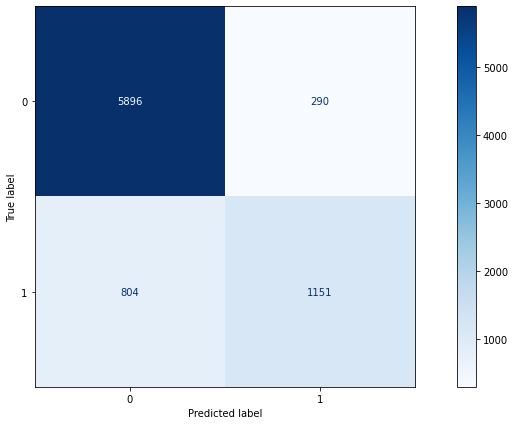

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(m1, X_test_1, y_test_1, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

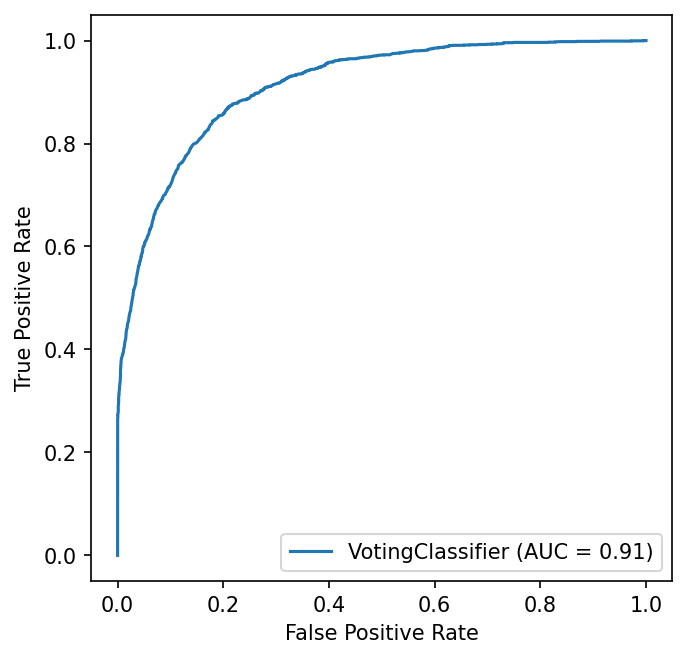

In [8]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(m1, X_test_1, y_test_1, ax=ax)
plt.show()

In [9]:
roc_auc_score(y_test_1, m1.predict_proba(X_test_1)[:, 1])

0.9124202576066904

Vemos que se obtiene un valor de RocAUC bastante alto

## Modelo 2 - Preprocessing Significantes 90%

Utilizaremos para este primer modelo a todos los modelos (cuyas métricas son decentes) entrenados con el preprocessing base, estos serán:

* KNN
* LogisticRegression
* RandomForest

Veamos qué pasa!

In [11]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, Y, stratify=Y, random_state=112)

X_train_2, X_test_2 = preprocessing_significantes(X_train_2, X_test_2, 0.9)

/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['ganancia_perdida_declarada_bolsa_argentina'] = X_train['ganancia_perdida_declarada_bolsa_argentina'].apply(_log_scale)
/home/lukas/FIUBA/tp-datos-1c2021-de-angelis-riva-continanza/Parte2/preprocessing.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ganancia_perdida_declarada_bolsa_argentina'] = X_test['ganancia_perdida_declarada_bolsa_argentina'].apply(

In [14]:
m2_knn = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=30)
m2_lrc = LogisticRegression(C=0.03162277660168379, l1_ratio=0.1, penalty='elasticnet', solver='saga')
m2_rfc = RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=450, n_jobs=-1, random_state=27)
m2 = VotingClassifier(estimators=[('knn', m2_knn),
                                  ('lrc', m2_lrc),
                                  ('rfc', m2_rfc)],
                                  voting='soft', n_jobs=-1, verbose=4)

In [15]:
m2.fit(X_train_2, y_train_2)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   n_neighbors=30)),
                             ('lrc',
                              LogisticRegression(C=0.03162277660168379,
                                                 l1_ratio=0.1,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('rfc',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=11,
                                                     n_estimators=450,
                                                     n_jobs=-1,
                                                     random_state=27))],
                 n_jobs=-1, verbose=4, voting='soft')

In [16]:
print(classification_report(y_test_2, m2.predict(X_test_2), digits=4))

              precision    recall  f1-score   support

           0     0.8739    0.9261    0.8992      6181
           1     0.7128    0.5786    0.6387      1960

    accuracy                         0.8424      8141
   macro avg     0.7933    0.7523    0.7690      8141
weighted avg     0.8351    0.8424    0.8365      8141



Vemos que nuevamente no es lo que esperábamos para Voting. Un accuracy de 84.2%, bastante similar que los modelos estándar.

Veamos las otras métricas.

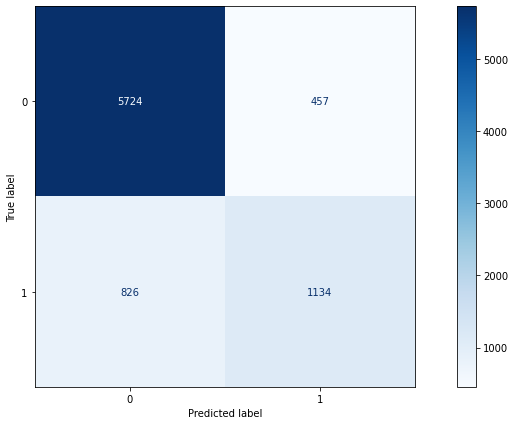

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
plt.grid(False)
plot_confusion_matrix(m2, X_test_2, y_test_2, cmap=plt.cm.Blues, display_labels=['0', '1'], ax=ax)
plt.show()

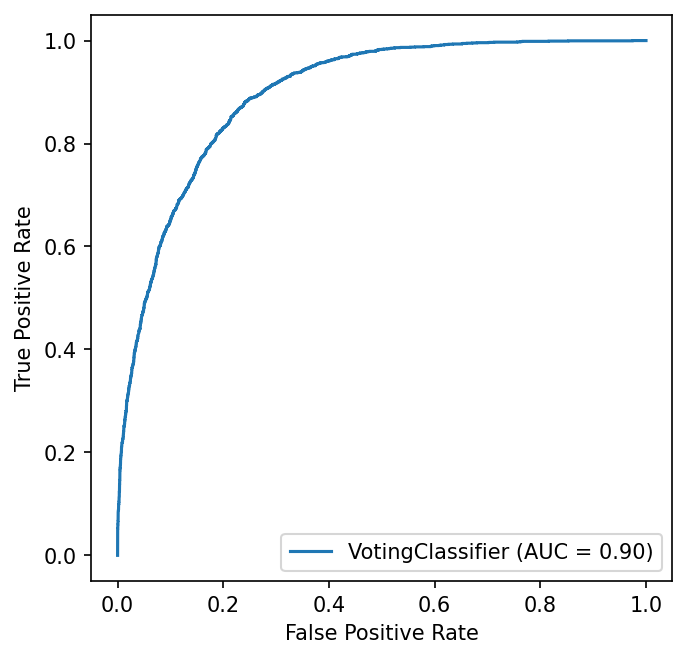

In [18]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plot_roc_curve(m2, X_test_2, y_test_2, ax=ax)
plt.show()

In [19]:
roc_auc_score(y_test_2, m2.predict_proba(X_test_2)[:, 1])

0.8971241691952627

Vemos que, si bien no deja de ser un resultado aceptable, no está entre los mejores que obtuvimos y es ampliamente superado por el primer Voting que entrenamos.

# Predicción de HoldOut

Usaremos para predecir el Voting obtenido para el preprocessing Base.

In [20]:
def holdout():
    ids, X = utils.get_holdout_data()    
    X, _ = preprocessing_base_parte_1(X, X)
    return ids, X

In [21]:
ids, X = holdout()

In [22]:
utils.escribir_holdout(m1.predict(X), "11 - Voting", ids)